# Installing required Packages 

In [1]:
!pip install -q ultralytics roboflow

In [2]:
import tensorflow as tf
import os
from roboflow import Roboflow
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd

# Downloading the dataset locally

In [3]:
rf = Roboflow(api_key="0VZYY90r4l05ICemwLNZ")
project = rf.workspace("selfdriving-car-qtywx").project("self-driving-cars-lfjou")
version = project.version(6)
dataset = version.download("yolov8")

!mv ./Self* ./dataset
!cd dataset && rm data.yaml README*

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Cars-6 in yolov8:: 100%|██████████| 9950/9950 [00:00<00:00, 10754.34it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


# Merging all the dataset images and labels

In [4]:
import shutil
from sklearn.model_selection import train_test_split

def merge_directories(base_dir, output_dir):

    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for folder in ['test', 'train', 'valid']:
        for subfolder in ['images', 'labels']:
            src_path = os.path.join(base_dir, folder, subfolder)
            if os.path.exists(src_path):
                for file in os.listdir(src_path):
                    src_file = os.path.join(src_path, file)
                    if os.path.isfile(src_file):
                        shutil.copy(src_file, os.path.join(output_dir, subfolder, file))


base_dir = "./dataset"
output_dir = "./combined_dataset"

In [5]:
merge_directories(base_dir, output_dir)

print("Processing complete. Directoy contents were merged successfully.")

Processing complete. Directoy contents were merged successfully.


# Splitting the dataset

In [6]:
def split_dataset(images_dir, labels_dir, output_dir, test_ratio=0.2, val_ratio=0.2):

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    image_files.sort()
    label_files.sort()

    images_train, images_temp, labels_train, labels_temp = train_test_split(image_files, label_files, test_size=test_ratio + val_ratio, random_state=15)

    test_size = test_ratio / (test_ratio + val_ratio)

    images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size=test_size, random_state=15)

    subsets = {
        'train': (images_train, labels_train),
        'test': (images_test, labels_test),
        'valid': (images_val, labels_val)
    }

    for subset, (image_list, label_list) in subsets.items():
        subset_images_dir = os.path.join(output_dir, subset, 'images')
        subset_labels_dir = os.path.join(output_dir, subset, 'labels')
        os.makedirs(subset_images_dir, exist_ok=True)
        os.makedirs(subset_labels_dir, exist_ok=True)

        for image, label in zip(image_list, label_list):
            shutil.copy(os.path.join(images_dir, image), subset_images_dir)
            shutil.copy(os.path.join(labels_dir, label), subset_labels_dir)

In [7]:
random_split_data = './Split_Dataset'
images_dir = os.path.join(output_dir, './images')
labels_dir = os.path.join(output_dir, './labels')

split_dataset(images_dir, labels_dir, random_split_data)

print("Processing complete. Classes extracted and dataset split successfully.")

Processing complete. Classes extracted and dataset split successfully.


# Organizing the images by folders based on classes

In [8]:
import shutil

classes = {
    '0':'Green Light',
    '1':'Red Light',
    '2':'Speed Limit 10',
    '3':'Speed Limit 100',
    '4':'Speed Limit 110',
    '5':'Speed Limit 120',
    '6':'Speed Limit 20',
    '7':'Speed Limit 30',
    '8':'Speed Limit 40',
    '9':'Speed Limit 50',
    '10':'Speed Limit 60',
    '11':'Speed Limit 70',
    '12':'Speed Limit 80',
    '13':'Speed Limit 90',
    '14':'Stop' }


def organize_images_by_class(image_dir, label_dir, output_dir):

    os.makedirs(output_dir, exist_ok=True)

    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            if not lines:
                print(f"Warning: {label_file} is empty. Skipping.")
                continue
            first_class_id = classes[lines[0].split()[0]]

        image_name = os.path.splitext(label_file)[0]
        image_path = os.path.join(image_dir, f"{image_name}.jpg")


        class_dir = os.path.join(output_dir, first_class_id)
        os.makedirs(class_dir, exist_ok=True)

        shutil.copy(image_path, class_dir)

    print("Organizing complete successfully.")


In [9]:
image_train_directory = os.path.join(random_split_data, './train/images')
label_train_directory = os.path.join(random_split_data, './train/labels')
output_train_directory = "./train"

organize_images_by_class(image_train_directory, label_train_directory, output_train_directory)

Organizing complete successfully.


In [10]:
image_valid_directory = os.path.join(random_split_data, './valid/images')
label_valid_directory = os.path.join(random_split_data, './valid/labels')
output_valid_directory = "./valid/"

organize_images_by_class(image_valid_directory, label_valid_directory, output_valid_directory)

Organizing complete successfully.


In [11]:
image_test_directory = os.path.join(random_split_data, './test/images')
label_test_directory = os.path.join(random_split_data, './test/labels')
output_test_directory = "./test/"

organize_images_by_class(image_test_directory, label_test_directory, output_test_directory)

Organizing complete successfully.


# Initialization variables

In [12]:
BATCH_SIZE = 16
IMAGE_SIZE = 416
CHANNELS = 3
EPOCHS = 250
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Loading the different datasets from their respective directories

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    output_train_directory,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2978 files belonging to 15 classes.


In [14]:
valid_data = tf.keras.utils.image_dataset_from_directory(
    output_valid_directory,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 993 files belonging to 15 classes.


In [15]:
test_data = tf.keras.utils.image_dataset_from_directory(
    output_test_directory,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
    )

Found 994 files belonging to 15 classes.


In [16]:
class_names = train_data.class_names
num_classes = len(class_names)

# Building the Model

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.3),
    layers.GaussianNoise(stddev=0.15),
])

def return_model():
    l2_reg = regularizers.l2(0.001)  # L2 regularization factor

    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    x = resize_and_rescale(inputs)

    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 5
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Feature Learning
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layers
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.4)(x)  # Dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2_reg)(x)

    return models.Model(inputs, outputs)

model = return_model()

In [18]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 416, 416, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 416, 416, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 416, 416, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 416, 416, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 416, 416, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 416, 416, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 208, 208, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 208, 208, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 208, 208, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 208, 208, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 208, 208, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 208, 208, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 104, 104, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 104, 104, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 104, 104, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 104, 104, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 104, 104, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 104, 104, 128)  │             

 Total params: 7,622,703 (29.08 MB)

 Trainable params: 7,617,711 (29.06 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [19]:
model_8 = return_model()
model_16 =  return_model()
model_32 = return_model()
models = [model_8, model_16, model_32]

# Call-backs

In [20]:
import tensorflow as tf

class BestWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_accuracy = 0.0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restoring the best weights based on validation accuracy: {self.best_val_accuracy}")

class EarlyStoppingAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, patience=20):
        super().__init__()
        self.patience = patience
        self.wait = 0
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Stopping training early after {self.patience} epochs with no improvement in validation accuracy.")
                self.model.stop_training = True

best_weights_callback8 = BestWeightsCallback()
early_stopping_callback8 = EarlyStoppingAccuracy(patience=50)

best_weights_callback16 = BestWeightsCallback()
early_stopping_callback16 = EarlyStoppingAccuracy(patience=50)

best_weights_callback32 = BestWeightsCallback()
early_stopping_callback32 = EarlyStoppingAccuracy(patience=50)

In [36]:
import tensorflow as tf

# Function to return a learning rate scheduler based on batch size
def get_lr_schedule(batch_size):
    decay_steps = {
        8: 10000,   # Decay steps for batch size 8
        16: 5000,   # Decay steps for batch size 16
        32: 2500    # Decay steps for batch size 32
    }
    
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=decay_steps.get(batch_size, 10000),  # Default to batch size 8 if not found
        decay_rate=0.9
    )

lr_schedule_8 = get_lr_schedule(batch_size=8)
lr_schedule_16 = get_lr_schedule(batch_size=16)
lr_schedule_32 = get_lr_schedule(batch_size=32)

In [37]:
model_8.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_8), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics = ['accuracy'])

model_16.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_16), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics = ['accuracy'])

model_32.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_32), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics = ['accuracy'])

# Training and evaluating every model

In [30]:
!mkdir saved_models

mkdir: cannot create directory 'saved_models': File exists


In [38]:
history_8 = model_8.fit(
    train_data,
    epochs = EPOCHS,
    batch_size = 8,
    verbose = 1,
    validation_data=valid_data,
    callbacks=[best_weights_callback8, early_stopping_callback8]
)

model_8.save('./saved_models/8.keras')

Epoch 1/250


I0000 00:00:1733918891.757435     101 service.cc:145] XLA service 0x7e201c004bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733918891.757515     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/373 ━━━━━━━━━━━━━━━━━━━━ 2:13:45 22s/step - accuracy: 0.0000e+00 - loss: 5.6454

I0000 00:00:1733918906.758663     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_6', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_5', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion', 36 bytes sp

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1293 - loss: 5.0347

I0000 00:00:1733918946.739822     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_6', 104 bytes spill stores, 108 bytes spill loads



373/373 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - accuracy: 0.1293 - loss: 5.0325 - val_accuracy: 0.1118 - val_loss: 3.8153
Epoch 2/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.1586 - loss: 3.1637 - val_accuracy: 0.0967 - val_loss: 2.9613
Epoch 3/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1575 - loss: 2.8136 - val_accuracy: 0.1148 - val_loss: 2.7567
Epoch 4/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1693 - loss: 2.6887 - val_accuracy: 0.1229 - val_loss: 2.7715
Epoch 5/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1682 - loss: 2.6567 - val_accuracy: 0.1158 - val_loss: 2.9278
Epoch 6/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1567 - loss: 2.6348 - val_accuracy: 0.1118 - val_loss: 2.7670
Epoch 7/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1793 - loss: 2.5781 - val_accuracy: 0.1108 - val_loss: 3.0989
Epoch 8/250
373/373 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.1581 - loss: 2.5878 - val

In [39]:
for i in range(10):
    model_8.evaluate(test_data)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6810 - loss: 1.6379
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6792 - loss: 1.6210
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6897 - loss: 1.5886
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6800 - loss: 1.6184
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6755 - loss: 1.6438
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6859 - loss: 1.6051
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6851 - loss: 1.5913
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6856 - loss: 1.5885
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6828 - loss: 1.6053
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6891 - loss: 1.5681


In [41]:
history_16 = model_16.fit(
    train_data,
    epochs = EPOCHS,
    batch_size = 16,
    verbose = 1,
    validation_data=valid_data,
    callbacks=[best_weights_callback16, early_stopping_callback16]
)

model_16.save('./saved_models/16.keras')

Epoch 1/250


2024-12-11 14:28:41.622473: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,416,416]{3,2,1,0}, f32[16,32,416,416]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-11 14:28:41.638667: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.016320249s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,416,416]{3,2,1,0}, f32[16,32,416,416]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

  1/187 ━━━━━━━━━━━━━━━━━━━━ 1:20:56 26s/step - accuracy: 0.0000e+00 - loss: 6.2071

I0000 00:00:1733927329.698205     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_17', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 4 bytes spill stores, 12 bytes spill loads



187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1146 - loss: 5.2517

I0000 00:00:1733927363.556278     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_6', 104 bytes spill stores, 108 bytes spill loads



187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.1148 - loss: 5.2483 - val_accuracy: 0.0715 - val_loss: 4.1068
Epoch 2/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.1536 - loss: 3.5513 - val_accuracy: 0.0665 - val_loss: 3.3601
Epoch 3/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.2014 - loss: 2.9279 - val_accuracy: 0.1017 - val_loss: 3.4532
Epoch 4/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.1926 - loss: 2.7499 - val_accuracy: 0.0906 - val_loss: 3.0961
Epoch 5/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.2157 - loss: 2.6547 - val_accuracy: 0.2145 - val_loss: 2.6636
Epoch 6/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.1947 - loss: 2.6228 - val_accuracy: 0.1682 - val_loss: 2.7113
Epoch 7/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.2190 - loss: 2.6225 - val_accuracy: 0.1440 - val_loss: 2.6176
Epoch 8/250
187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.2172 - loss: 2.549

In [42]:
for i in range(10):
    model_16.evaluate(test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7627 - loss: 1.2898
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7729 - loss: 1.2874
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7645 - loss: 1.2706
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7690 - loss: 1.2237
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7563 - loss: 1.3079
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7634 - loss: 1.3044
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7606 - loss: 1.2826
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7530 - loss: 1.3516
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7644 - loss: 1.2969
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7695 - loss: 1.2719


In [44]:
history_32 = model_32.fit(
    train_data,
    epochs = EPOCHS,
    batch_size = 32,
    verbose = 1,
    validation_data=valid_data,
    callbacks=[best_weights_callback32, early_stopping_callback32]
)

model_32.save('./saved_models/32.keras')

Epoch 1/250


2024-12-11 16:33:53.552938: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,416,416]{3,2,1,0}, f32[32,32,416,416]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-11 16:33:54.672836: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.120077539s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,416,416]{3,2,1,0}, f32[32,32,416,416]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.1478 - loss: 5.4756

I0000 00:00:1733934878.348184     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_6', 104 bytes spill stores, 108 bytes spill loads



94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 398ms/step - accuracy: 0.1481 - loss: 5.4706 - val_accuracy: 0.0725 - val_loss: 6.3765
Epoch 2/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.1941 - loss: 3.9807 - val_accuracy: 0.0564 - val_loss: 3.8899
Epoch 3/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.2053 - loss: 3.3553 - val_accuracy: 0.1047 - val_loss: 3.3627
Epoch 4/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 303ms/step - accuracy: 0.2190 - loss: 2.9883 - val_accuracy: 0.1662 - val_loss: 3.1305
Epoch 5/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.2403 - loss: 2.7973 - val_accuracy: 0.1793 - val_loss: 3.1447
Epoch 6/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.2510 - loss: 2.7350 - val_accuracy: 0.1793 - val_loss: 3.1190
Epoch 7/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.2797 - loss: 2.5741 - val_accuracy: 0.2014 - val_loss: 2.9427
Epoch 8/250
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.2790 - loss: 2.5115 - val_accuracy

In [45]:
for i in range(10):
    model_32.evaluate(test_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8720 - loss: 0.8590
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8647 - loss: 0.9036
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8799 - loss: 0.8182
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8751 - loss: 0.8704
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8644 - loss: 0.9093
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8669 - loss: 0.8594
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8783 - loss: 0.8193
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8642 - loss: 0.8518
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8699 - loss: 0.8588
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8668 - loss: 0.8688


# Visualizing Accuracy Improvements

In [46]:
def visualize_accuracy(history,EPOCHS):
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(30, 10))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), accuracy, label = 'Training Accuracy')
    plt.plot(range(EPOCHS), validation_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation accuracy')

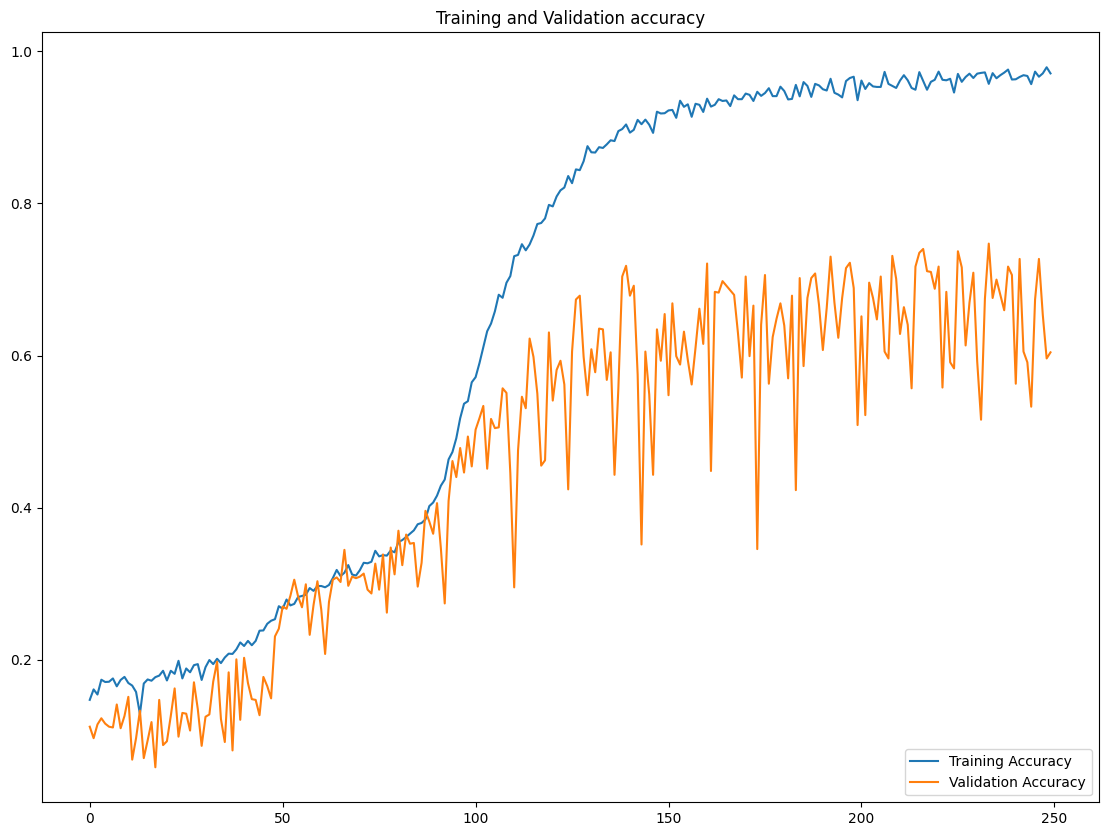

In [47]:
visualize_accuracy(history_8,EPOCHS)

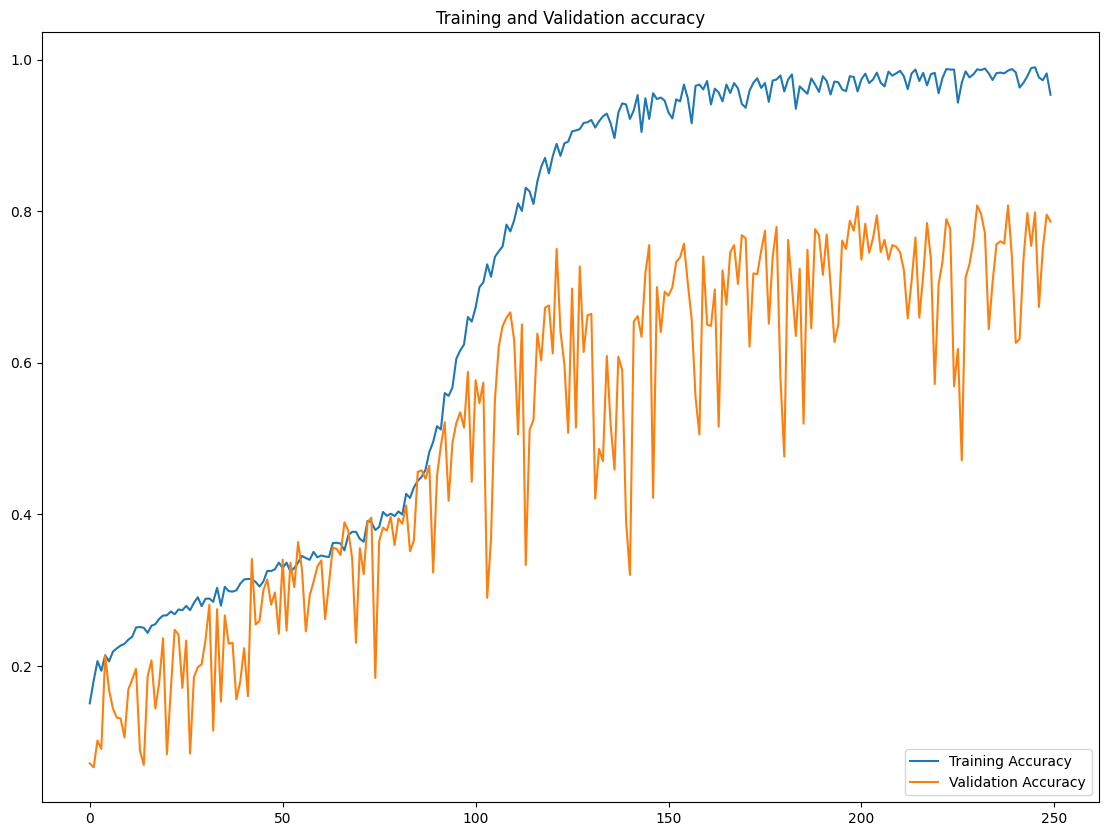

In [48]:
visualize_accuracy(history_16,EPOCHS)

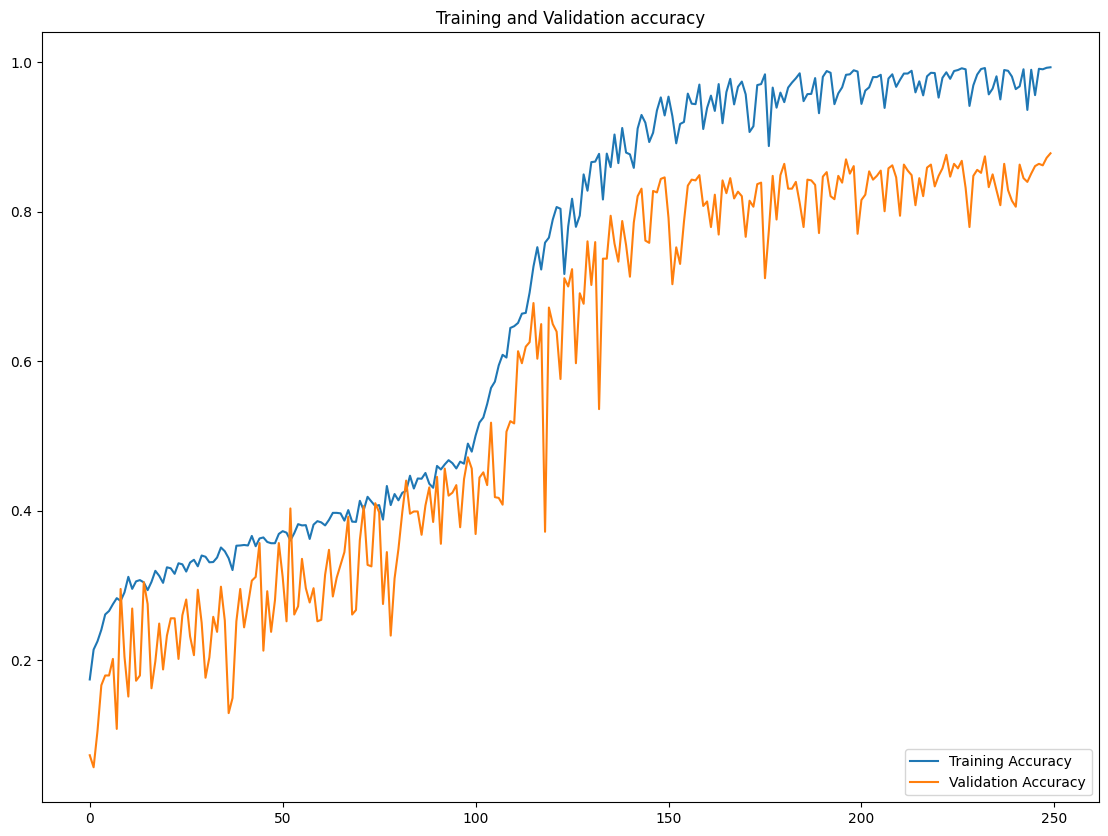

In [49]:
visualize_accuracy(history_32,EPOCHS)

# Visualizing Loss Improvements

In [50]:
def visualize_loss(history, EPOCHS):
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    plt.figure(figsize=(30, 10))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), loss, label = 'Training Loss')
    plt.plot(range(EPOCHS), validation_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation loss')
    plt.show()

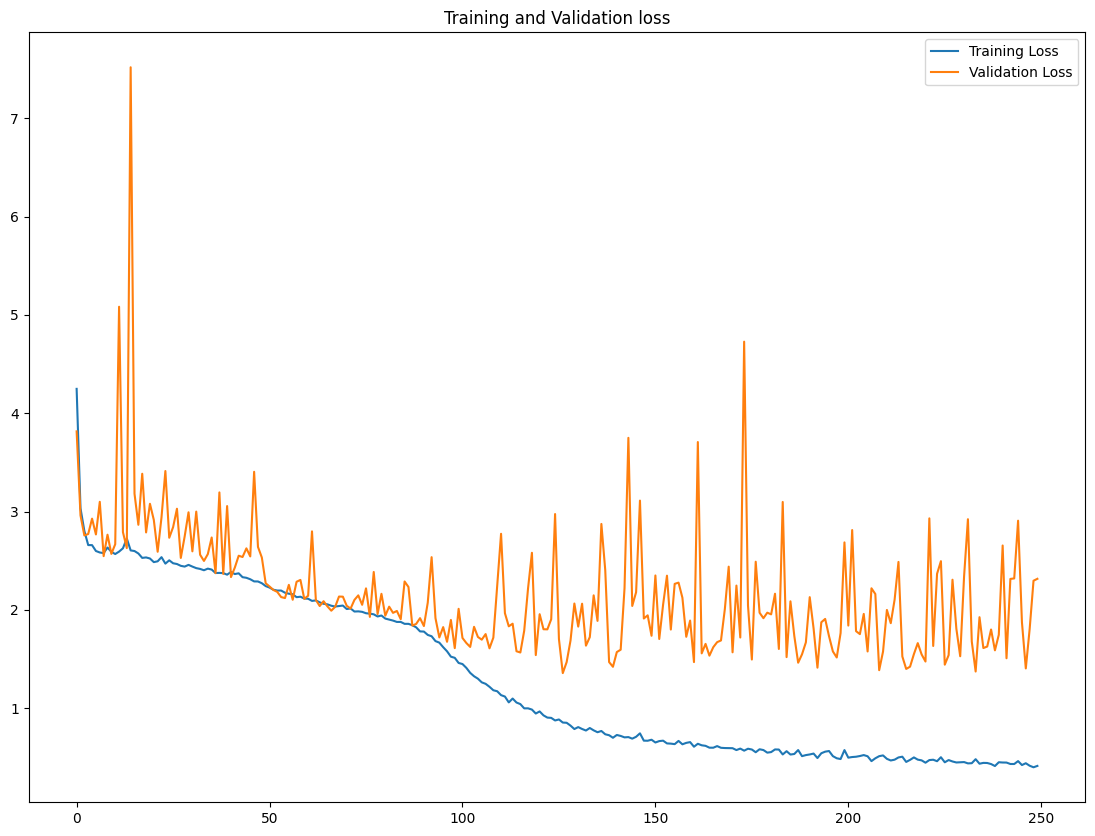

In [51]:
visualize_loss(history_8, EPOCHS)

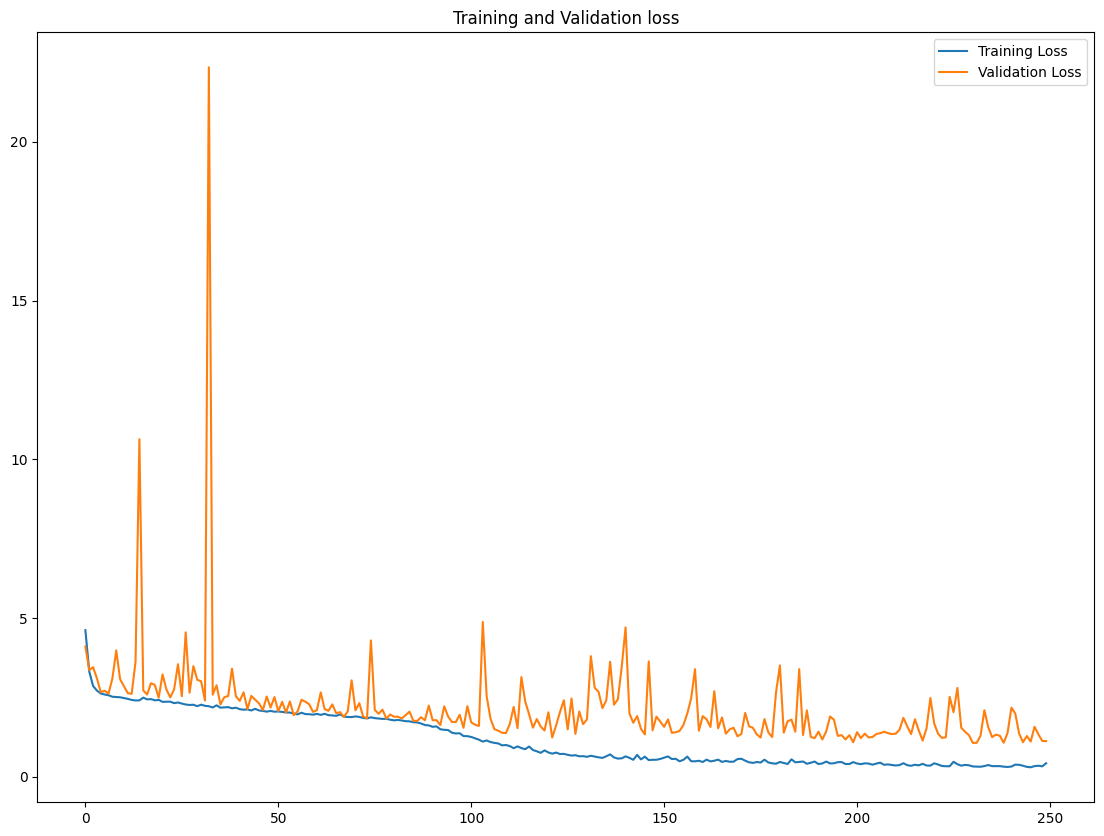

In [52]:
visualize_loss(history_16, EPOCHS)

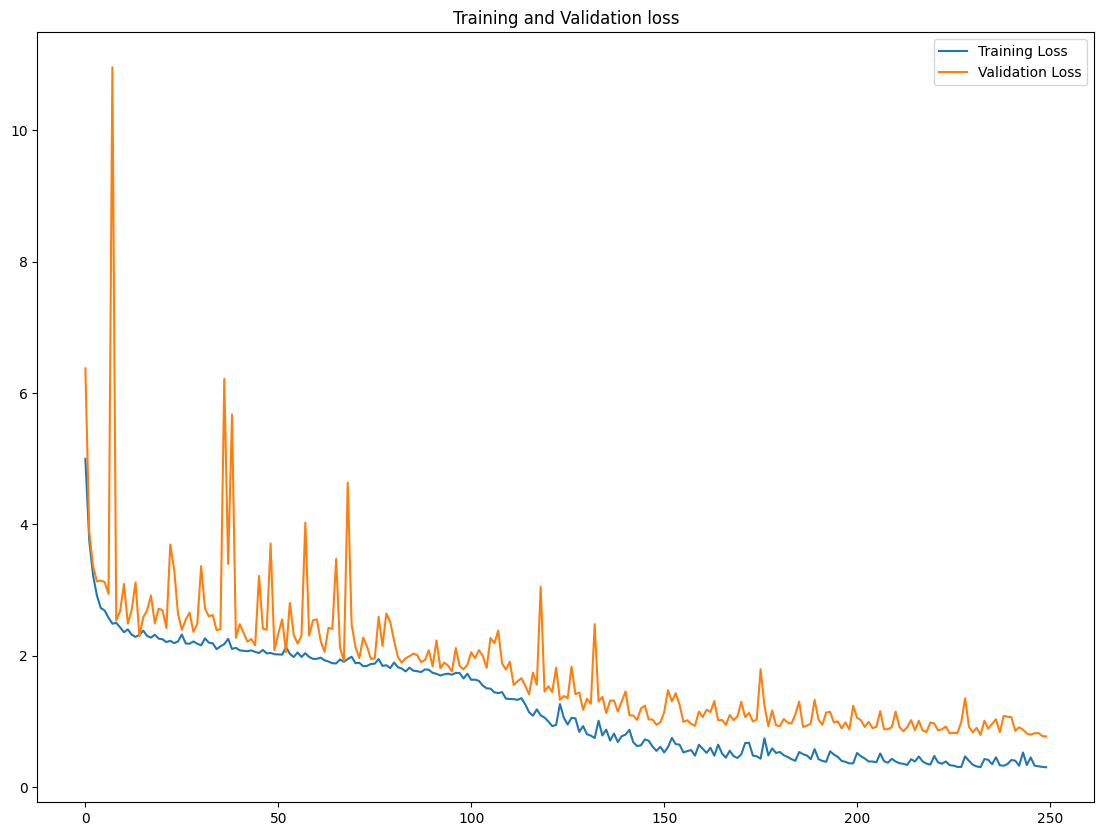

In [53]:
visualize_loss(history_32, EPOCHS)

# Confusion Matrix

In [54]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def confusion_m(model):
    class_names = test_data.class_names
    
    true_labels = []
    predicted_labels = []
    for images, labels in test_data:
        true_labels.extend(labels.numpy())
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━

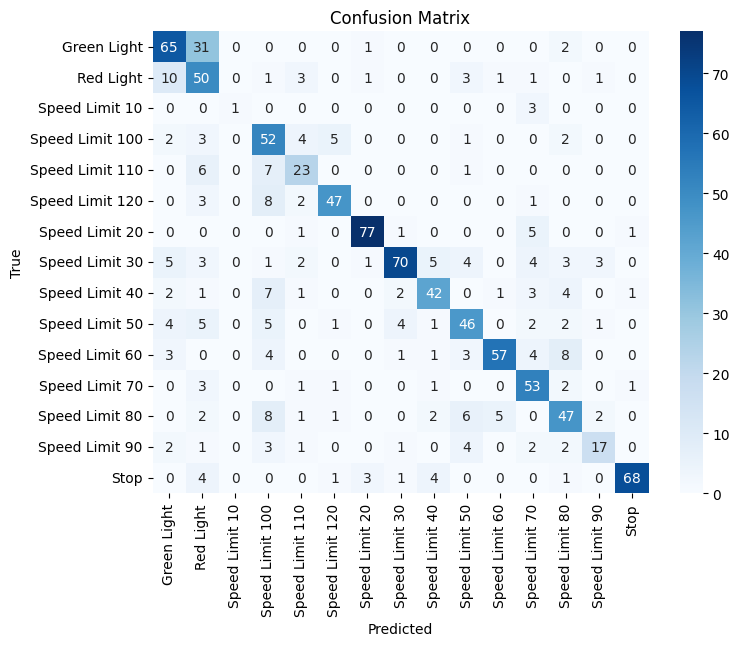

In [55]:
confusion_m(model_8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━

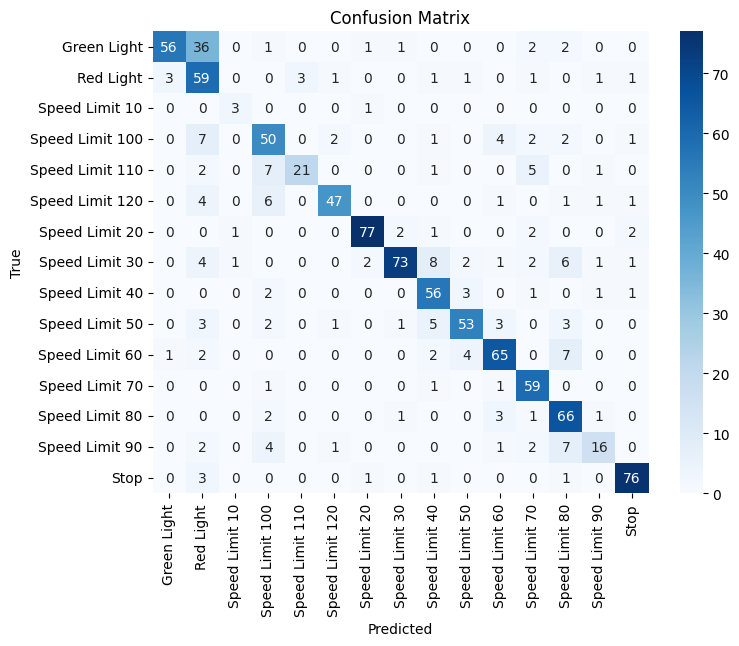

In [56]:
confusion_m(model_16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━

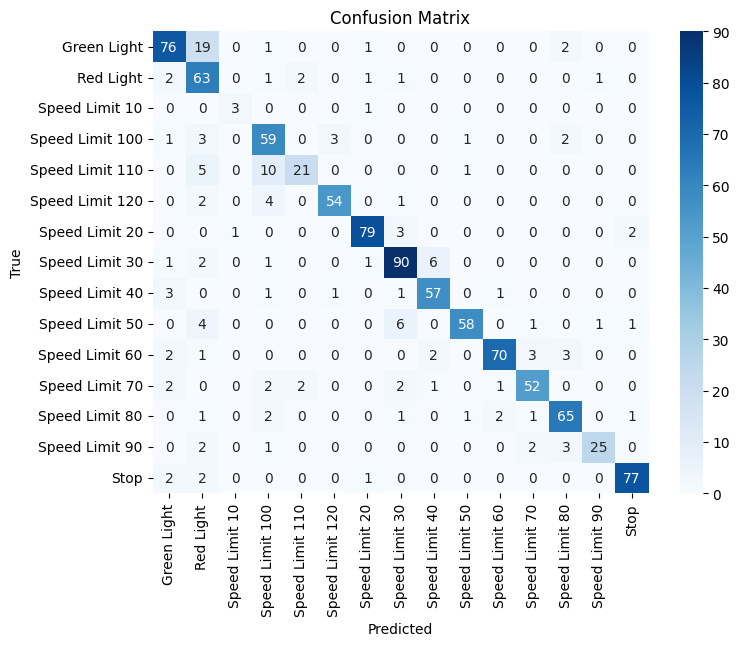

In [57]:
confusion_m(model_32)

# Precision and Recall

In [58]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

def compute_precision_recall(model, dataset):
    """
    Computes and prints precision and recall for a given TensorFlow model and dataset.
    
    Parameters:
        model (tf.keras.Model): The TensorFlow model to evaluate.
        dataset (tf.data.Dataset): A dataset created with image_dataset_from_directory.
    
    Returns:
        None
    """
    # Get all images and labels from the dataset
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        # Predict the labels for the current batch of images
        predictions = model.predict(images, verbose=0)  # Get probabilities
        predicted_classes = tf.argmax(predictions, axis=1)  # Convert to class indices
        
        # Append true labels and predicted labels
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes.numpy())
    
    # Calculate precision and recall
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    
    # Print the results
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [59]:
compute_precision_recall(model_8, test_data)

Precision: 0.7468
Recall: 0.7193


In [60]:
compute_precision_recall(model_16, test_data)

Precision: 0.8128
Recall: 0.7817


In [61]:
compute_precision_recall(model_32, test_data)

Precision: 0.8665
Recall: 0.8541
